In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import emachine as EM

from sklearn.preprocessing import OneHotEncoder

In [2]:
np.random.seed(0)

In [3]:
def generate_interactions(n,m,g,sp,i1i2):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    
    # sparse
    for i in range(n):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        for j in range(n):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            if (np.abs(j-i) > 1) and (np.random.rand() < sp): 
                w[i1:i2,j1:j2] = 0.
    
    # sum_j wji to each position i = 0                
    for i in range(n):        
        i1,i2 = i1i2[i,0],i1i2[i,1]             
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            

    # no self-interactions
    for i in range(n):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        w[i1:i2,i1:i2] = 0.   # no self-interactions

    # symmetry
    for i in range(nm):
        for j in range(nm):
            if j > i: w[i,j] = w[j,i]       
        
    return w

In [4]:
def ops_w_true(s,n_var,w_true):
    #input: s[n_seq, n_var*m]: one hot   
    n_seq,nm = s.shape
    m = int(nm/float(n_var))

    n_ops = int((m-1)*n_var + ((m-1)**2)*n_var*(n_var-1)/2.)
        
    ops = np.zeros((n_seq,n_ops))
    w_true_ops = np.zeros(n_ops)

    iops = 0
    # linear terms    
    for i in range(n_var):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        for ia in range(i1,i2-1):
            ops[:,iops] = (s[:,ia] - s[:,i2-1])
            w_true_ops[iops] = 0. # set bias_true = 0 for simulation data
            
            iops += 1
    
    # quadratic terms
    for i in range(n_var-1):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        for j in range(i+1,n_var):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            for ia in range(i1,i2-1):
                for jb in range(j1,j2-1):
                    ops[:,iops] = (s[:,ia] - s[:,i2-1])*(s[:,jb] - s[:,j2-1])
                    w_true_ops[iops] = w_true[ia,jb]
                    iops += 1
    
    return ops,w_true_ops

In [5]:
def generate_seq(w_true,n_seq,n_var,m,n_sample=30):
    samples = np.random.choice(np.arange(m),size=(n_seq*n_sample,n_var),replace=True)

    onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
    s = onehot_encoder.fit_transform(samples)

    ops,w_true_ops = ops_w_true(s,n_var,w_true)
    energy = ops.dot(w_true_ops)

    p = np.exp(energy)
    p /= np.sum(p)

    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)

    #return samples[out_samples],w_true_ops
    return ops[out_samples],w_true_ops

In [6]:
def fit(ops,n_var,m,eps=0.1,max_iter=100,alpha=0.1):    
    n_linear = int((m-1)*n_var)
    n_quad = int(((m-1)**2)*n_var*(n_var-1)/2.)
    
    cov = np.hstack([np.full(n_linear,2./m),np.full(n_quad,4./(m**2))])
    
    E_av = np.zeros(max_iter)
    n_ops = ops.shape[1]

    np.random.seed(13)
    w = np.random.rand(n_ops)-0.5    
    for i in range(max_iter):              
        #energies_w = energy_ops(ops,w)
        energies_w = ops.dot(w)        
        energies_max = energies_w.max()
        
        # to avoid a too lager value:
        probs_w = np.exp((energies_w-energies_max)*(eps-1)) 
        z_data = np.sum(probs_w)
        probs_w /= z_data
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)

        E_av[i] = energies_w.mean()  
        w += alpha*(ops_expect_w - eps*w*cov)
      
    return w,-E_av[-1]

In [7]:
n = 10; m = 4; g = 2. ; sp = 0.0

#mx = np.array([len(np.unique(s0[:,i])) for i in range(n)])
mx = np.array([m for i in range(n)])
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

w_true = generate_interactions(n,m,g,sp,i1i2)

#plt.imshow(w_true,cmap='rainbow',origin='lower')

In [8]:
n_seq = 10000
n_sample = 30
n_var = n

In [9]:
ops,w_true_ops = generate_seq(w_true,n_seq,n_var,m,n_sample=30)

In [10]:
eps_list = np.linspace(0.1,0.9,9)
E_eps = np.zeros(len(eps_list))
w_eps = np.zeros((len(eps_list),ops.shape[1]))
for i,eps in enumerate(eps_list):
    w_eps[i,:],E_eps[i] = fit(ops,n_var,m,eps=eps,max_iter=100)
    print(eps,E_eps[i])

0.1 -5.105426000415221
0.2 -5.106129232092607
0.30000000000000004 -5.190192347014249
0.4 -5.3583982818692775
0.5 -5.627018099020796
0.6 -6.034377708508537
0.7000000000000001 -6.660954409868771
0.8 -7.69239426132689
0.9 -9.69190990427864


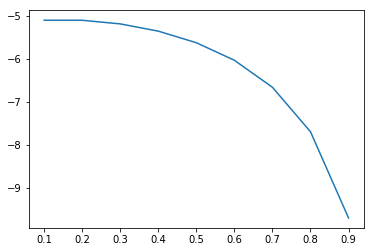

In [11]:
plt.plot(eps_list,E_eps)

In [12]:
ieps = np.argmax(E_eps)
w_pred = w_eps[ieps]
print('optimal eps:', eps_list[ieps])

optimal eps: 0.1


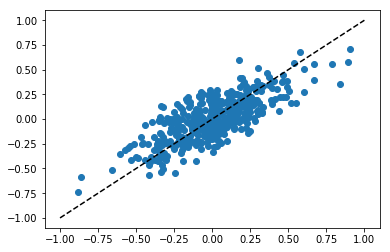

In [13]:
plt.plot([-1,1],[-1,1],'k--')
plt.scatter(w_true_ops,w_pred)

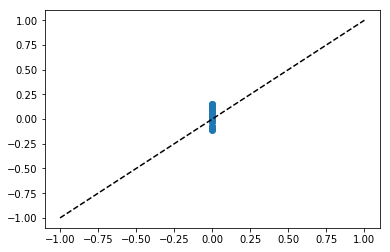

In [16]:
plt.plot([-1,1],[-1,1],'k--')
plt.scatter(w_true_ops[:20],w_pred[:20])